# Introduction au Reinforcement Learning #2 #

Seconde partie de notre petit introduction au reinforcement learning. On a vu dans la première partie une manière intuitive d'entrainer un agent à résoudre un jeu de morpion que l'on pourrait appliquer à d'autres jeu ou d'autres scénarios mais il est temps de mettre un peu de théorie.

*Ok mais juste un peu hein ?*

Ok ok vraiment juste ce qu'il faut pour avancer. Promis.

## Un peu de théorie ##

Reprenons les bases. De quoi avons nous besoins ? D'un **agent** et d'un **environnement**. Quel est le but de l'agent ? De parcourir l'environnement, d'apprendre et de trouver le parcours optimal.

*ok... ça reste assez vague là, non ?*

Oui mais on va illustrer ça avec un peu de code pour mieux comprendre. Commençons par définir un environnement. Imaginons un carré découpé en 9 cases. (un peu comme notre grille de Morpion)

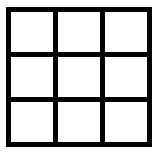

Là c'est un environnement **très très simple** et completement **connu** (un environnement pourrait être partielement connu voir inconnu) pour illustrer mais bien entendu on peu avoir des environnements beaucoup plus compliqué. Rien que pour notre jeu du Morpion l'environnement sera tous les coups possibles !

In [1]:
# Création de notre environnement de base
def create_env(size):
    '''Create a square empty environnement
    -size : number of case in line'''
    return [[0 for i in range(size)] for j in range(size)]

# Il est constitué de 3 lignes de 3 cases que l'on peu définir avec une liste comme ci-dessous
env = create_env(3)
        
env

[[0, 0, 0], [0, 0, 0], [0, 0, 0]]

Maintenant nous pouvons mettre un agent dans notre environnement et le faire explorer. Notre agent sera simplement représenté par les coordonnées d'une case. On sera donc où il se trouve dans l'environnement.

In [103]:
# Appelons notre ami Boris et plongeons le dans l'environnement au hasard
import random
random.seed(777)

boris = (random.randint(0, 2), random.randint(0,2))

print('Boris se trouve sur la case à l\'intersection de la ligne', boris[0], 'et de la colonne', boris[1], 'de notre environnement.')

Boris se trouve sur la case à l'intersection de la ligne 0 et de la colonne 1 de notre environnement.


Voilà notre agent infiltré Boris se trouve donc là :
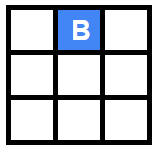

*Cool !*

Maintenant faut dire à notre agent de se déplacer pour **explorer** l'environnement. Mais comme il est un peu bête-bête, il va falloir lui dire comment faire. Pour ça on va lui donner une rêgle de déplacement qu'on appelera **POLICY** représenté par le symbole **π**.

*Ooooh... Mais comment qu'on fait ça concrétement ?*

Ah et bien libre à vous, on parle de théorie là faut que ça s'adapte à toutes les situation et sytèmes.

*Mais euh... Chais pas moi :(*

Ok ok. On va définir une policy pour notre agent pour donner un exemple. Qu'est-ce qu'on pourrait faire ? ... On a qu'à dire tout simplement que notre agent peut se déplacer dans n'importe quelle direction de façon aléatoire avec la même proba. Comme notre environnement nous impose de nous déplacer de droite à gauche ou de haut en bas (Bon j'avoue c'est moi qui vient de décider que l'environnement fonctionne comme ça !), notre agent aura 0.25 chance d'aller dans une direction. On aurait pu choisir une autre rêgle, genre il a 80% de chance d'aller vers le bas ou quand il fait beau il va en haut et quand il fait gris il va en bas ! Encore une fois on est libre (pour l'instant...)

Allez, programmons notre policy pour notre agent

In [124]:
# Créons une fonction de déplacement qui suit la policy définie
def deplacement(limit, position, direction=-1, probability=1):
    '''fonction de deplacement de l'agent
    - limit : taille limite de l'env. où se trouve l'agent
    - position : position de l'agent (tuple)
    - direction : direction choisie de l'agent (int)
    - probability : probabilité de l'agent d'aller dans la bonne direction
    '''
    if direction == -1 :
        direction = random.randint(0,3)
    elif random.random() > probability:
        directions = [d for d in range(4)]
        directions.remove(direction)
        direction = random.choice(directions)
            
    if direction == 0 and position[0] - 1 >= 0: # déplacement vers le haut si possible
        new_position = (position[0] - 1, position[1])
    elif direction == 1 and position[1] + 1 < limit: # déplacement vers la droite
        new_position = (position[0], position[1] + 1)
    elif direction == 2 and position[0] + 1 < limit: # déplacement vers le bas
        new_position = (position[0] + 1, position[1])
    elif direction == 3 and position[1] - 1 >= 0: # déplacement vers la gauche
        new_position = (position[0], position[1] - 1)
    else:
        # Déplacement impossible
        new_position = False
    return new_position

# Déplaçons Boris selon notre policy
random.seed(777)
boris = deplacement(len(env), boris)

print('Nouvel emplacement de Boris :', boris)

Nouvel emplacement de Boris : (0, 1)


Voilà notre agent s'est déplacé selon la policy et se retrouve là :
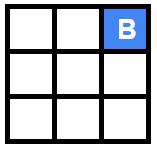

On peut continuer comme ça et faire **explorer** l'environnement en entier par l'agent. Bon comme ça, ça sert pas à grand chose. Boris peut se déplacer indéfinement dans l'environnement mais là il apprend rien.

*Bah oui il est un peu nul l'environnement. Faudrait y rajouter des trucs qui puissent intéresser Boris.*

Oui du coup on va étoffer un peu notre environnement. Voyons voir...

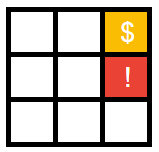

Voilà ! Maintenant il y a des sous-sous dans une des cases et un danger dans une autre. Du coup on peut echainer sur la notion de **récompense** (**reward**), on peut dire que si Boris arrive sur la case "$" il obtient une **récompense positive** et si il tombe dans la case "!", là il obtient une **récompense négative**.

Du coup maintenant, Boris à un but noble et beau : amasser le plus de pognon !!!

*Bon c'est bien gentil mais comment on traduit ça en code ?*

Bonne question et bien donnons une valeur à nos "$" et "!". Par la même occasion on va mettre zéro pour les cases neutres, sans récompense ni danger.

In [4]:
# Modification de l'environnement
new_env = create_env(3)

new_env[0][2] = 1
new_env[1][2] = -1

new_env

[[0, 0, 1], [0, 0, -1], [0, 0, 0]]

Bon maintenant on peut faire évoluer Boris dans l'environnement et voir combien de pépettes il peut récupérer ^^

In [5]:
# On donne une tirelire à Boris où mettre ses sous
tirelire = 0 # Elle est vide au début off course

# On fait une boucle pour laisser Boris explorer 100 fois l'environnement
exploration = 100
while exploration > 0:
    boris = (2, 0) # Par commodité on lâche Boris toujours au même endroit
    explore = True
    while explore:
        pi = random.randint(0,3) # On reprend notre policy
        
        # Boris se déplace
        new_boris = deplacement(3, boris)
        if new_boris:
            boris = new_boris
            
        # On récupère la valeur de la case et on la met dans sa poche
            tirelire += new_env[boris[0]][boris[1]]
        
        # On vérifie si l'exploration est terminée (arrivé sur la case "$" ou "!")
        if boris == (0, 2) or boris == (1, 2):
            explore = False
            
    exploration -= 1
    
print("Fin de l'exploration de Boris.")
print("Gains de Boris :", tirelire, "$")

Fin de l'exploration de Boris.
Gains de Boris : -34 $


*WHAAAAAT !! Mais il a pas du tout gagner d'argent le Boris !*

Oui on voit bien qu'il est plus souvent tombé sur la case piège que sur la case gain. Et c'est normal au vu de la case de départ et de la policy (déplacement aléatoire). Notre **policy** n'est donc pas optimale.

*Comment avoir une meilleure policy ?*

Et bien il faut que notre agent puisse déterminer la **valeur** de ses déplacements, de ses **actions**. Il va nous falloir un nouveau concept théorique. Dites bonjour à la **Value Function** !

## Un peu plus de théorie ##

La **Value Function** sert à determiner la **valeur d'un état et/ou d'une action**. Pour déterminer ces valeurs on va retropropager la récompense dans l'environnement. Ainsi Boris poura "obtenir/voir" une partie de la récompense selon ses déplacements. Intuitivement cela correspond à donner une valeur plus grande au déplacement qui se rapproche de la récompense.

La value function va calculer l'espérance de gain de tous les états de l'environnement.

Allez comme vous aimez les maths :

$$ v(s) = E [G_{t} | S_{t} = s] $$
$$ G_{t} = \sum_{k=0}^{\infty} \gamma^{k}R_{t+k+1}$$
$s$ = état, $t$ = temps, $\gamma$ = discount factor (coefficient d'actualisation), $G$ = Fonction de gain, $R$ = récompense

Bon allez ! Ralez pas, c'était juste pour vous embêter ;) En gros, ça dit juste que la value function à l'état "s" est l'éspérance (la moyenne) des gains futurs.

Et pour simplifier les choses on va utiliser l'**équation de Bellman** qui est la version récurrente de la value function.

$$ v(s) = E [R_{t+1} + \gamma.v(S_{t+1}) | S_t = s]$$

*Salaud !*

Mais non, mais non pas d'inquiétude on va tout comprendre en calculant la value fonction pour notre petit environnement. Donc pour rappel notre environnement ressemble à ça pour l'agent :
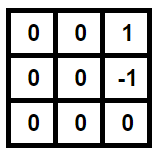

Et l'agent se déplace selon une politique random soit toutes les directions ont la même probabilité. Calculons la value function.

In [140]:
# Comme c'est un peu compliqué de la calculer d'un seul coup on va calculer une première fois pour chaque case (état)
# Et on va faire une fonction pour ne pas à recommencer d'écrire le code à chaque fois ^^
# On ajoute aussi quelques arguments qui nous servirons plus tard
def VF(env, end_state, if_out, proba=1, policy='random', info=False):
    '''Calcul la value function pour un etat
    - env : environnement (listxlist)
    - end_state : les états de fin (gain ou perte) (listxtuple)
    - if_out : comportement si direction en dehors de l'environnement (None ou int)
    - proba : probabilité du déplacement choisi (float{0,1})
    - policy : les choix de déplacement ('random' ou listxlist == env.size)
    - info : pour afficher les étapes de calcul (boolean)
    '''
    v = [ligne.copy() for ligne in env]
    v_new = [ligne.copy() for ligne in env]
    size = len(env)
    for ligne in range(size):
        for colonne in range(size):
            # On vérfie qu'on est pas sur une case de fin
            if (ligne, colonne) not in end_state:
                # On prend la valeur de la case selon la direction si elle existe
                haut = v[ligne-1][colonne] if ligne > 0 else if_out
                bas = v[ligne+1][colonne] if ligne < size - 1 else if_out
                droite = v[ligne][colonne+1] if colonne < size - 1 else if_out
                gauche = v[ligne][colonne-1] if colonne > 0 else if_out
            
                # on actualise la valeur moyenne de la case de notre value function (à l'exception des case '$' et '!')
                directions = [haut, droite, bas, gauche]
                if policy == 'random':
                    directions = [v for v in directions if v is not None] # On retire les directions impossibles si existe
                    v_new[ligne][colonne] = sum(directions) / len(directions)
                else:
                    v_direction = directions.pop(policy[ligne][colonne]) # On récupère la valeur de la direction de la policy
                    directions = [v for v in directions if v is not None]
                    v_new[ligne][colonne] = v_direction * proba + sum(directions) * (1 - proba) / len(directions)
                
                # Print les étapes si spécifié
                if info:
                    print("Calcul de l'état (case) :", (ligne, colonne), ': (', \
                          haut, '+', droite, '+', bas, '+', gauche, ') / ', len(directions), ' = ', v_new[ligne][colonne])
    return v_new

v1 = VF(new_env, [(0,2), (1,2)], 0, info=True)

v1

Calcul de l'état (case) : (0, 0) : ( 0 + 0 + 0 + 0 ) /  4  =  0.0
Calcul de l'état (case) : (0, 1) : ( 0 + 1 + 0 + 0 ) /  4  =  0.25
Calcul de l'état (case) : (1, 0) : ( 0 + 0 + 0 + 0 ) /  4  =  0.0
Calcul de l'état (case) : (1, 1) : ( 0 + -1 + 0 + 0 ) /  4  =  -0.25
Calcul de l'état (case) : (2, 0) : ( 0 + 0 + 0 + 0 ) /  4  =  0.0
Calcul de l'état (case) : (2, 1) : ( 0 + 0 + 0 + 0 ) /  4  =  0.0
Calcul de l'état (case) : (2, 2) : ( -1 + 0 + 0 + 0 ) /  4  =  -0.25


[[0.0, 0.25, 1], [0.0, -0.25, -1], [0.0, 0.0, -0.25]]

Donc voilà, pour chaque case nous avons calculé la moyenne des gains/valeurs que l'on peut obtenir pour chaque directions à partir de cette case.

on a calculé : $ v(s_t) = E[v(s_{t+1})] $

*Hé mais il manque le $R$ et le $\gamma$ !*

Le $R$ on le calcul que lorsqu'on arrive sur une case de fin (cas particulier de notre environnement) donc c'est normal et le $\gamma$, c'est une valeur qu'on utilise pour atténuer l'influence des états proportionnelement de l'état actuel. En gros cela veut dire qu'on accorde plus d'importance dans le process de décision aux états proches. En tout cas pas trés utile pour notre exemple et du coup ici le on $\gamma = 1$ dans la pratique on le mets souvent à $0,9$.

Résultat :

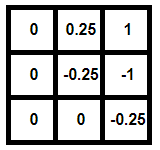

*Hé mais c'est super !!! Mais ça sert à quoi ?*

Attends, c'est pas fini. Pour avoir la Value Function réelle, il faut itérer ce process une infinité de fois !

*What ! Mais c'est n'importe quoi !*

Oui bon ok, l'infini c'est pas atteignable. Du coup faut choisir une stratégie pour se rapprocher au plus près de la VF réelle sans que ce soit trop pénalisant d'un point de vu ressources. Il y'en a plusieurs, par exemple on peut regarder si l'écart entre les mises à jour des valeurs devient très petit. Mais en général on atteint des valeurs acceptables bien avant car finalement l'important c'est d'avoir des valeurs qui représente bien l'intéret d'une case par rapport aux autres, peu importe la valeur exacte qu'elle devrait avoir... C'est pas clair ?

Bon recommençons notre process 2 ou 3 fois

In [141]:
v2 = VF(v1, [(0,2), (1,2)], 0)
display(v2)

v3 = VF(v2, [(0,2), (1,2)], 0)
display(v3)

[[0.0625, 0.1875, 1], [-0.0625, -0.1875, -1], [0.0, -0.125, -0.25]]

[[0.03125, 0.21875, 1],
 [-0.03125, -0.25, -1],
 [-0.046875, -0.109375, -0.28125]]

Résultat :
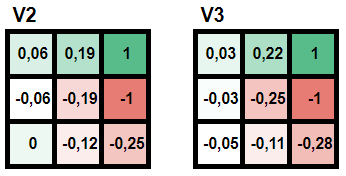

In [142]:
# Pour le fun
v_old = [ligne.copy() for ligne in v3]

for x in range(10000): # presque l'infini non ?
    v_new = VF(v_old, [(0,2), (1,2)], 0)
    v_old = [ligne.copy() for ligne in v_new]

v_new

[[0.030844881537773806, 0.1935628073312472, 1],
 [-0.07018328118015198, -0.25659365221278496, -1],
 [-0.054984354045596776, -0.1497541350022351, -0.2874385337505588]]

Soit :
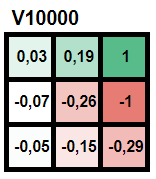

On voit que l'odre des cases par valeurs est le même après 10000 itération que celui après 3 itérations. Dans la pratique, l'infini n'est pas nécessaire.

*Ok super mais encore une fois, ça sert à quoi ?*

Et bien justement ça sert à **évaluer notre policy**. En effet si on avait eu un policy différente la VF aurait été différente également.

Maintenant, roulement de tambour ... **brbrbrbrbrbrbrbrbr** ... Nous pouvons en déduire le chemin **optimal** !! Et donner une nouvelle policy à Boris !! Une **optimal policy** que nous nommerons **π**

*Ooooh Show me the money !!*

Yes, on se calme. Il suffit de dire à notre de se déplacer en fonction des valeurs de la value function. Allons'y

In [143]:
# D'abord on définit notre optimal policy avec notre v_new (ou v3 ça marche aussi ^^)
def optimal_policy(vf, end_state):
    '''définit notre optimal policy
    - vf : résultat de la value function ou policy evaluation (listxlist)
    '''
    size = len(vf)
    policy = [ligne.copy() for ligne in vf]
    for ligne in range(size):
        for colonne in range(size):
            if (ligne, colonne) not in end_state:
                haut = vf[ligne-1][colonne] if ligne > 0 else None
                bas = vf[ligne+1][colonne] if ligne < size - 1 else None
                droite = vf[ligne][colonne+1] if colonne < size - 1 else None
                gauche = vf[ligne][colonne-1] if colonne > 0 else None

                directions = [haut, droite, bas, gauche]
                dir_true = [v for v in directions if v is not None] # On retire les directions impossibles si existe
                policy[ligne][colonne] = directions.index(max(dir_true))
            else:
                policy[ligne][colonne] = vf[ligne][colonne]
                
    return policy

v_pi = optimal_policy(v_new, [(0,2), (1,2)])

v_pi

[[1, 1, 1], [0, 0, -1], [0, 3, 3]]

In [144]:
# Reprenons Boris avec sa tirelire vide (on est gentil on efface sa dette précédente)
tirelire = 0

size = len(new_env)
# Boris va une nouvelle parcourir 100 fois l'env.
exploration = 100
while exploration > 0:
    boris = (2, 0) # Par commodité on lâche Boris toujours au même endroit
    explore = True
    while explore:
        # Boris se déplace avec sa nouvelle policy
        boris = deplacement(size, boris, v_pi[boris[0]][boris[1]])
        if boris == (0, 2) or boris == (1, 2):
            tirelire += new_env[boris[0]][boris[1]] # on lui donne sa récompense
            explore = False
            
    exploration -= 1
    
print("Fin de l'exploitation GREEDY de l'environnement par Boris.")
print("Gains de Boris :", tirelire, "$")

Fin de l'exploitation GREEDY de l'environnement par Boris.
Gains de Boris : 100 $


*Boris est riche !!!*

Ouais d'ailleurs faut pas trop le laisser se balader dans l'environnement là, ou sinon je vais être ruiné !

Voilà nous avons permis à Boris de **plannifier** un parcours optimal pour avoir sa récompense. Si on détail sa nouvelle policy elle ressemblera à ça :
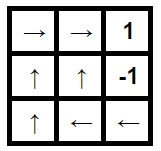

Petit rappel de ce que l'on a vu :
- Agent
- Environnement
- Policy
- Value Function
- Equation de Bellman

Ce que nous avons fait c'est une **POLICY EVALUATION** qui nous a permis de **PLANNIFIER** une **OPTIMAL POLICY**. Cette solution n'est pas appliquable à toutes les situations.
Ses limites :
- On doit connaitre entièrement l'environnement ou le **modèle** qui caractérise l'environnement. C'est un **model base algorythm**
- Elle ne permet pas d'obtenir la meilleur policy dans tous les environnement.

Mais nous allons avoir qu'il y'a des moyens d'améliorer tout ça :)

## Encore plus de Théorie !##

*Encore ?! On en a soupé là. Quand est-ce qu'on revient à notre jeu de Morpion ?*

Et bien j'aimerais bien aussi :( Mais il faut comprendre que notre simple jeu de Morpion a un environnement plus complexe qu'il n'y parait. Bien que théoriquement on puisse déterminer tous les états possible du jeu, le nombre est assez élevé et du coup pas évident à mettre en place avec notre théorie d'apprentissage actuelle.

Du coup je prospose qu'on étoffe un peu notre grille actuelle pour complexifié un peu le problème.

On va faire grossir notre environnement de 5 cases ! Il fera donc 8x8 cases ! On va aussi rajouté plus de cases pièges disons 4 répartis aléatoirement et on va perturber le comportement de Boris !

*Hein comment on va faire ça ?*

Bah on va faire boire Boris jusqu'à ce qu'il soit assez saoul pour qu'il ne maîtrise pas bien ces mouvements. Ainsi quand il vaudra aller dans une direction, il aura une probabilité non nulle d'aller dans une autre direction ! Voilà qui devrait bien complexifier notre environnement et l'apprentissage de Boris.

*Mouais C'est pas très éthique tout ça !*

In [149]:
# Création du nouvel environnement
gros_env = create_env(8)

# Ajout de pièges
random.seed(777)
for p in range(4):
    gros_env[random.randint(0,7)][random.randint(0,7)] = -1
    
# Ajout des sous-sous
gros_env[7][7] = 1

gros_env

[[0, 0, 0, 0, 0, 0, 0, -1],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, -1],
 [0, 0, 0, 0, 0, -1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, -1, 0, 1]]

Voilà notre nouvel environnement :
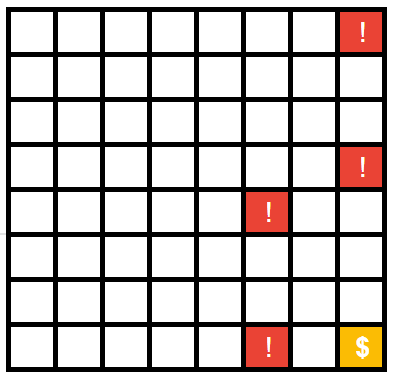

Maintenant appliquons notre stratégie élaborée précedement avec notre Boris bourré.

In [150]:
# On va faire une petit fonction pour récupérer les états de fin
def etats_fin(env):
    ef = []
    for ligne in range(len(gros_env)):
        for colonne in range(len(gros_env)):
            if gros_env[ligne][colonne] != 0:
                ef.append((ligne, colonne))
    return ef

etats_fin = etats_fin(gros_env)

etats_fin

[(0, 7), (3, 7), (4, 5), (7, 5), (7, 7)]

In [355]:
# Et une autre pour créer une policy au hasard
def policy(env, end_state):
    '''définit une policy au hasard
    - env : l'environnement pour notre policy (listxlist)
    - end_state : liste des états de fin (listextuple)
    '''
    size = len(env)
    policy = [ligne.copy() for ligne in env]
    for ligne in range(size):
        for colonne in range(size):
            if (ligne, colonne) not in end_state:
                policy[ligne][colonne] = random.randint(0, 3)
            else:
                policy[ligne][colonne] = None
    return policy

random.seed(777)

pi0 = policy(gros_env, etats_fin)

pi0

[[1, 3, 3, 2, 2, 2, 0, None],
 [3, 3, 2, 0, 0, 0, 2, 0],
 [0, 2, 2, 2, 0, 1, 2, 1],
 [3, 0, 2, 1, 0, 2, 3, None],
 [0, 3, 1, 0, 3, None, 2, 1],
 [3, 0, 3, 1, 3, 0, 3, 2],
 [2, 1, 0, 1, 0, 0, 0, 3],
 [2, 2, 0, 1, 0, None, 3, None]]

In [356]:
# Estimons notre VF avec Boris bourré
v_new = [ligne.copy() for ligne in gros_env]

for t in range(10000): # 10000 cycle chosit arbitrairement mais ça devrait largement converger
    v_old = [ligne.copy() for ligne in v_new]
    v_new = VF(v_old, etats_fin, -1, 0.8, pi0) # -1 si la direction choisie est impossible pour décourager Boris d'aller dans le mur
    if t >= 9998:
        print(v_new[0]) # pour comparer et determiner si ça converge bien
    
vf_gros_env = [ligne.copy() for ligne in v_new]

[[round(v,2) for v in ligne] for ligne in vf_gros_env]

[-0.9999934670211585, -0.9999920028273606, -0.999975641930425, -0.9998858758788071, -0.9998334853869062, -0.9997357732008805, -0.9999387989238786, -1]
[-0.9999934670211585, -0.9999920028273606, -0.999975641930425, -0.9998858758788071, -0.9998334853869062, -0.9997357732008805, -0.9999387989238786, -1]


[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1, -0.99, -0.99],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.99, -0.87],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.97, -0.83],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1, -0.86, 1]]

In [357]:
# Création de notre nouvelle optimal policy
pi1 = optimal_policy(vf_gros_env, etats_fin)
pi1

[[1, 1, 2, 1, 1, 2, 2, -1],
 [1, 1, 2, 2, 1, 2, 2, 3],
 [1, 1, 1, 1, 1, 1, 2, 3],
 [1, 1, 1, 2, 2, 1, 2, -1],
 [1, 1, 1, 2, 2, -1, 2, 2],
 [1, 2, 1, 2, 1, 1, 1, 2],
 [1, 1, 1, 1, 1, 1, 1, 2],
 [1, 1, 1, 0, 0, -1, 1, 1]]

*Bah à ça à l'air bon non ? On peut s'arrêter là.*

Et bien on va tester.

- Boris ! Viens je t'invite à prendre un verre !

Maintenant on peut balancer notre Boris saoul dans l'environnement et voir comment il se débrouille avec sa nouvelle policy

In [358]:
random.seed(777)

tirelire = 0 # Bah oui il est saoul ! Il a tout dépenser dans l'alcool
exploration = 100
size = len(gros_env)
while exploration > 0:
    boris = (0, 0)
    explore = True
    while explore:
        mouv = deplacement(len(gros_env), boris, pi1[boris[0]][boris[1]], 0.8)
        if mouv != False:
            boris = mouv 
        if boris in etats_fin:
            tirelire += gros_env[boris[0]][boris[1]]
            explore = False
            
    exploration -= 1
    
print("Fin de l'exploration de Boris.")
print("Gains de Boris saoul :", tirelire, "$")

Fin de l'exploration de Boris.
Gains de Boris saoul : 64 $


*Ah ouais le Boris bourré est moins efficace !*

Du coup on peut se demander s'il y a une autre policy possible qui soit plus efficace pour le Boris bourré. Alors comment on fait ça ?

## Policy Iteration ##

*Oh non qu'est ce que c'est que ça :(*

Le mieux c'est de décrire l'algo directement je crois :
1. On determine une policy **π** arbitraire
2. On calcul les valeurs d'état selon π
3. On determine la policy qui max nos gain avec cette value function
4. Si cette dernière policy est différente de la policy d'avant on recommence

Bon c'est pas trés clair comme ça j'en convient. Essayons de mettre ça en pratique.

In [359]:
# Reprenons la dérnière policy de Boris et evaluons là
random.seed(777)

# Estimons notre VF avec Boris bourré
v_new = [ligne.copy() for ligne in gros_env]

for t in range(10000):
    v_old = [ligne.copy() for ligne in v_new]
    v_new = VF(v_old, etats_fin, -1, 0.8, pi1)
    if t >= 9998:
        print(v_new[0])
    
v1_gros_env = [ligne.copy() for ligne in v_new]

[[round(v,2) for v in ligne] for ligne in v1_gros_env]


[0.013670217606366539, 0.16363622559137062, 0.25678231234856375, 0.09724149041923173, 0.15325192952964772, 0.23818512149516924, 0.15682541070828548, -1]
[0.013670217606366539, 0.16363622559137062, 0.25678231234856375, 0.09724149041923173, 0.15325192952964772, 0.23818512149516924, 0.15682541070828548, -1]


[[0.01, 0.16, 0.26, 0.1, 0.15, 0.24, 0.16, -1],
 [0.24, 0.36, 0.38, 0.36, 0.34, 0.36, 0.34, 0.15],
 [0.29, 0.4, 0.4, 0.38, 0.37, 0.37, 0.37, 0.18],
 [0.41, 0.53, 0.55, 0.56, 0.43, 0.3, 0.39, -1],
 [0.45, 0.57, 0.59, 0.59, 0.44, -1, 0.52, 0.44],
 [0.43, 0.55, 0.6, 0.6, 0.55, 0.54, 0.66, 0.67],
 [0.41, 0.56, 0.59, 0.61, 0.63, 0.65, 0.8, 0.83],
 [0.11, 0.27, 0.37, 0.47, 0.4, -1, 0.72, 1]]

In [360]:
# On définit notre nouvelle policy à partir de v1
pi2 = optimal_policy(v1_gros_env, etats_fin)

pi2

[[2, 2, 2, 2, 2, 2, 2, -1],
 [1, 2, 2, 2, 2, 2, 2, 3],
 [2, 2, 2, 2, 2, 1, 2, 3],
 [1, 2, 2, 2, 3, 3, 2, -1],
 [1, 1, 2, 2, 3, -1, 2, 2],
 [1, 1, 1, 2, 2, 1, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 2],
 [0, 0, 0, 0, 0, -1, 1, 1]]

In [361]:
# On checke si pi_new == pi_old
pi1 == pi2

False

La nouvelle policy diffère de la précédente, du coup on recommence le process jusqu'à trouver le policy optimale

In [362]:
# Reprenons la dérnière policy de Boris et evaluons là
random.seed(777)

v_new = [ligne.copy() for ligne in gros_env]
for t in range(10000):
    v_old = [ligne.copy() for ligne in v_new]
    v_new = VF(v_old, etats_fin, -1, 0.8, pi2)

v2_gros_env = [ligne.copy() for ligne in v_new]

# On définit notre nouvelle policy à partir de v2
pi3 = optimal_policy(v2_gros_env, etats_fin)

# On compare les policy
pi3 == pi2

False

In [366]:
# On recommence temps que les policy ne sont pas identiques
v_new = [ligne.copy() for ligne in v2_gros_env]
pi_new = [ligne.copy() for ligne in pi3]
pi_old = [ligne.copy() for ligne in pi2]

i = 3

while pi_old != pi_new:
    i += 1
    pi_old = [ligne.copy() for ligne in pi_new]
    v_new = [ligne.copy() for ligne in gros_env]
    for t in range(10000):
        v_old = [ligne.copy() for ligne in v_new]
        v_new = VF(v_old, etats_fin, -1, 0.8, pi_old)

    v_old = [ligne.copy() for ligne in v_new]

    pi_new = optimal_policy(v_new, etats_fin)

    print(i, pi_old == pi_new)

optimal_pi = pi_new

print('nombre d\'itérations :', i)
print('policy optimale :')
optimal_pi

4 False
5 True
nombre d'itérations : 5
policy optimale :


[[2, 2, 2, 2, 2, 2, 2, -1],
 [1, 2, 2, 2, 2, 3, 3, 3],
 [1, 1, 2, 2, 3, 3, 3, 3],
 [1, 1, 2, 3, 3, 3, 2, -1],
 [1, 1, 2, 2, 2, -1, 2, 2],
 [1, 1, 1, 1, 2, 1, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 2],
 [1, 0, 0, 0, 0, -1, 1, 1]]

*Hourra ! On y est arrivé cette fois ! ... N'est ce pas ?*

Ah... oui, normalement ^^ Mais bon vaut mieux vérifier en live. Rebalançons notre Boris bourré dans l'environnement pour voir ce qu'il récolte avec notre nouvelle policy.

_Va vraiment faire plus attention à Boris, on risque d'avoir des plaintes de la ligue de protections des Boris..._

In [367]:
random.seed(777)

tirelire = 0 # Par soucis d'équité des tests scientifiques, on lui a piqué tous ses précédents gains.
exploration = 100 # Comme d'hab
size = len(gros_env)

while exploration > 0:
    boris = (0, 0)
    explore = True
    while explore:
        mouv = deplacement(len(gros_env), boris, optimal_pi[boris[0]][boris[1]], 0.8)
        if mouv != False:
            boris = mouv 
        if boris in etats_fin:
            tirelire += gros_env[boris[0]][boris[1]]
            explore = False
            
    exploration -= 1
    
print("Fin de la ballade optimale du Boris saoul.")
print("Gains de Boris:", tirelire, "$")

Fin de la ballade optimale du Boris saoul.
Gains de Boris: 74 $


*Ooooooh... **+10$**  C'est pas mal du tout !!*

*...*

*Est-ce qu'on ose demander...*

Quoi ?

*Ce... Ce serait possible de faire encore mieux ?*

**Argh quoi !? Vous en voulez encore !!!** J'en était sûr que vous finiriez par aimer la théorie (bon on a pas ma pratiqué là c'est vrai) Et bien, on peut faire un autre algo : la **VALUE ITERATION**

*Hum... Autant, on comprend l'intêret de la **Policy Iteration** mais la **Value Iteration**...*

Attendez que je vous explique ce que c'est au moins !

Allez go !

## Value Iteration ##

En fait c'est assez simple, on se dit que dès la première itération de l'estimation de notre Value Function pour une policy, la nouvelle policy que l'on peut obtenir de cette estimation très parcellaire de notre VF est au pire équivalente à l'ancienne polic, et au mieux elle est meilleure. Du coup on peut modifier notre policy à chaque itération de notre VF et théoriquement converger plus vite.

Allez, petite formule pour faire plaisir ^^

$$ v_{k+1}(s) = max_a E[r_{t+1} + \gamma.v_{k}(s_{t+1})|s_t = s, a_t = a] $$

*AAAAARGH !!! NOOOOON !!!!*

Hé ! On se calme c'est quasiment la même que la dernière fois ! On a juste rajouté des $k$ et $k+1$ juste pour dier qu'à chaque étape on prend l'action $max$ de l'espérance de nos gains afin de pouvoir en définir une policy à chaque itération.

Bon allez, ça suffit, on y va, ça sera plus simple bande de grognons !

In [372]:
# Bon d'abord on va créer une fonction VF spéciale Value Iteration
def VF_VI(env, end_state, if_out, proba=1):
    '''Calcul la value function pour un etat
    - env : environnement (listxlist)
    - end_state : les états de fin (gain ou perte) (listxtuple)
    - if_out : comportement si direction en dehors de l'environnement ('out' ou int)
    - proba : probabilité du déplacement choisi (float{0,1})
    '''
    v = [ligne.copy() for ligne in env]
    v_new = [ligne.copy() for ligne in env]
    size = len(env)
    for ligne in range(size):
        for colonne in range(size):
            if (ligne, colonne) not in end_state:
                haut = v[ligne-1][colonne] if ligne > 0 else if_out
                bas = v[ligne+1][colonne] if ligne < size - 1 else if_out
                droite = v[ligne][colonne+1] if colonne < size - 1 else if_out
                gauche = v[ligne][colonne-1] if colonne > 0 else if_out
                directions = [haut, droite, bas, gauche]

                directions = [v for v in directions if v != 'out']
                valeurs = [((proba*(len(directions)-1)-(1-proba))*v+(1-proba)*sum(directions))/(len(directions)-1) for v in directions]
                v_new[ligne][colonne] = max(valeurs)

    return v_new

# On reprend notre gros_env et appliquons une fois la value fonction en prenant les max
v1_vi = VF_VI(gros_env, etats_fin, 'out', 0.8)

[[round(v, 2) for v in ligne] for ligne in v1_vi]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, -1],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1],
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.07, -0.07, -1],
 [0.0, 0.0, 0.0, 0.0, -0.07, -1, -0.07, -0.1],
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.07, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.07, 0.0, 0.8],
 [0.0, 0.0, 0.0, 0.0, -0.1, -1, 0.7, 1]]

In [373]:
# On boucle jusqu'à s'approche d'une VF optimale
v_vi_new = [ligne.copy() for ligne in v1_vi]

t = 1
while t < 10000:
    v_vi_old = [ligne.copy() for ligne in v_vi_new]
    v_vi_new = VF_VI(v_vi_old, etats_fin, 'out', 0.8)
    t += 1
    
print('optimal value function :')
[[round(v, 2) for v in ligne] for ligne in v_vi_new]

optimal value function :


[[0.79, 0.79, 0.79, 0.79, 0.79, 0.77, 0.59, -1],
 [0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.76, 0.56],
 [0.79, 0.79, 0.79, 0.79, 0.79, 0.78, 0.75, 0.56],
 [0.79, 0.79, 0.79, 0.79, 0.77, 0.65, 0.65, -1],
 [0.79, 0.79, 0.79, 0.78, 0.67, -1, 0.78, 0.75],
 [0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.94, 0.96],
 [0.79, 0.79, 0.79, 0.79, 0.79, 0.81, 0.96, 0.99],
 [0.79, 0.79, 0.79, 0.77, 0.61, -1, 0.8, 1]]

In [374]:
# y'a plus qu'à faire notre optimal policy
vi_pi = optimal_policy(v_vi_new, etats_fin)

vi_pi

[[2, 3, 3, 3, 3, 3, 3, -1],
 [2, 3, 3, 3, 3, 3, 3, 3],
 [2, 3, 3, 3, 3, 3, 3, 3],
 [2, 3, 3, 3, 3, 0, 2, -1],
 [2, 2, 3, 3, 2, -1, 2, 2],
 [2, 2, 2, 2, 2, 1, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 2],
 [0, 0, 0, 0, 0, -1, 1, 1]]

In [375]:
# plus qu'à tester ^^
# Allez qu'on m'amène Boris et qu'on lui bourre la gueule ! (pov Boris :( ...)
random.seed(777)

tirelire = 0 # Qui a encore piqué les sous de Boris ! ça suffit maintenant !
exploration = 100
size = len(gros_env)

while exploration > 0:
    boris = (0, 0)
    explore = True
    while explore:
        mouv = deplacement(len(gros_env), boris, vi_pi[boris[0]][boris[1]], 0.8)
        if mouv != False:
            boris = mouv 
        if boris in etats_fin:
            tirelire += gros_env[boris[0]][boris[1]]
            explore = False
            
    exploration -= 1
    
print("Fin de parcours pour Boris... Il en peut plus le pauvre.")
print("Gains de Boris:", tirelire, "$")

Fin de parcours pour Boris... Il en peut plus le pauvre.
Gains de Boris: 80 $


***OOOOOOOH !!! IL A ENCORE GAGNE PLUS !!!***
*Doit être content finalement le Boris :) Et cette fois on lui laisse les sous hein ?*
Oui, oui promis on le laisse tranquille maintenant.

Bon on se fait un petit recap ?

|Algo               |Gains  |Différence  |
|:-----------------:|:---:|:----------:|
|Policy Improvement |64\$|   |
|Policy Iteration   |74\$|+10|
|Value Iteration    |80\$|+16|

Je ne sais pas vous mais je trouve ça beau ^^

Bon on a mérité notre pause !

A bientôt pour de futures aventures avec Boris dans l'univers du **Reinforcement Learning**

Bye bye ^^